# Funciones de activación redondeadas

**Autor**: <a href="https://www.linkedin.com/in/christian-oliva-moya-ingeniero/">Christian Oliva Moya</a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

En este notebook se pretende ilustrar con algunos ejemplos las ideas que hay detrás de implementar funciones de activación redondeadas en Tensorflow. Posibles casos de uso:

1. Redondeo de la función de activación de la capa de entrada para ser más robusto frente a ataques adversarios. Esta idea la utilizamos en el TFG de <a href="https://www.linkedin.com/in/javier-fontecha-guada%C3%B1o-a11a9a1ba/">Javier Fontecha Guadaño</a>: *"Defensa frente a ataques adversarios sobre redes neuronales convolucionales"* y nos ha dado muy buenos resultados. ¿De dónde viene la idea? Si un ataque adversario consiste en modificar ligeramente los datos de entrada para confundir al modelo, redondear implica que, aunque se modifique la entrada, la activación de la siguiente capa seguirá teniendo los mismos valores.

2. Redondeo a la salida de la capa de embedding de una red neuronal entrenada con NLP. Siguiendo la misma idea, si por lo que sea estás intentando encontrar vectores que representen lo mismo, este embedding no devolverá dos vectores similares para conceptos similares, sino que devolverá exactamente el mismo vector. Es realmente interesante en temas relacionados con la interpretabilidad de estas redes, por ejemplo, en análisis de sentimiento.

3. Redondeo en la función de activación de la capa recurrente de una RNN (ya sea Elman, LSTM o la que quieras). Si los estados de una RNN están normalmente acotados entre -1 y 1 por usar una tanh, ¿por qué no redondearla para tener neuronas discretizadas con valores -1, 0 ó 1? En mi tesis he explorado esta idea para temas de interpretabilidad y está dando muy buenos resultados.

4. Aplicar redondeo de la función sigmoide sobre una o varias variables para hacer una máscara booleana diferenciable. Esta idea, que la he explorado con <a href="https://www.linkedin.com/in/pedro-ramon-ventura-gomez/">Pedro Ventura</a>, nos ha llevado a publicar un entorno completo de optimización de carteras multi-objetivo implementado en Tensorflow.

In [ ]:
def pintar_figura(x, function, round_function, title, cortes, decimals=None, epsilon=1e-6):
    y = function(x)
    ry = round_function(x)

    plt.figure(figsize=(12, 3))
    plt.subplot(1,2,1)
    plt.title("$"+title+"$")
    plt.plot(x, y, '.')
    plt.xlabel("x")
    plt.ylabel("activation")
    for corte in cortes:
        plt.plot(corte, function(corte), 'o', color="orange", markersize=8)
        plt.axhline(function(corte), color="orange", alpha=0.2)
        plt.axvline(corte, color="orange", alpha=0.2)
    plt.subplot(1,2,2)
    if decimals is not None:
        plt.title("$round("+title+", decimals="+str(decimals)+")$")
    else:
        plt.title("$round("+title+")$")
    plt.plot(x, ry, '.')
    plt.plot(x, y, '-', alpha=0.3)
    for corte in cortes:
        plt.plot([corte-epsilon, corte+epsilon], [round_function(corte-epsilon), round_function(corte+epsilon)], 'o', color="orange", markersize=8)
        plt.axhline(round_function(corte-epsilon), color="orange", alpha=0.2)
        plt.axhline(round_function(corte+epsilon), color="orange", alpha=0.2)
        plt.axvline(corte, color="orange", alpha=0.2)
    plt.xlabel("x")
    plt.show()

In [ ]:
def pintar_derivada(x, function, round_function, title, decimals=None, epsilon=1e-6):
    x = tf.constant(x)

    with tf.GradientTape() as tape:
        tape.watch(x)
        y = function(x)
        dy_dx = tape.gradient(y, x)

    with tf.GradientTape() as tape:
        tape.watch(x)
        ry = round_function(x)
        dry_dx = tape.gradient(ry, x)

    plt.figure(figsize=(12, 3))
    plt.subplot(1,2,1)
    plt.title("Derivada de $"+title+"$")
    plt.plot(x, dy_dx, '.')
    plt.xlabel("x")
    plt.ylabel("derivada")

    plt.subplot(1,2,2)
    if decimals is not None:
        plt.title("Derivada de $round("+title+", decimals="+str(decimals)+")$")
    else:
        plt.title("Derivada de $round("+title+")$")
    plt.plot(x, dry_dx, '.')
    plt.plot(x, dy_dx, '.', alpha=0.05)
    plt.xlabel("x")
    plt.show()

In [ ]:
def inv_sigmoid(x):
    return np.log(x/(1-x))

## Sigmoide redondeada

In [ ]:
def round_sigmoid(decimals=0):
    @tf.custom_gradient
    def my_rounded_sigmoid(x):
        z = tf.nn.sigmoid(x)
        scale = 10**decimals
        output = tf.math.round(z * scale) / scale

        def backward(dy):
            custom_grad = z * (1 - z)
            return dy * custom_grad

        return output, backward
    return my_rounded_sigmoid

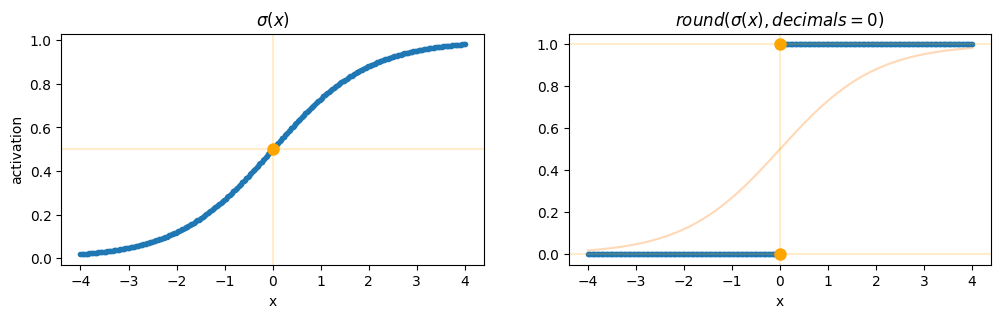

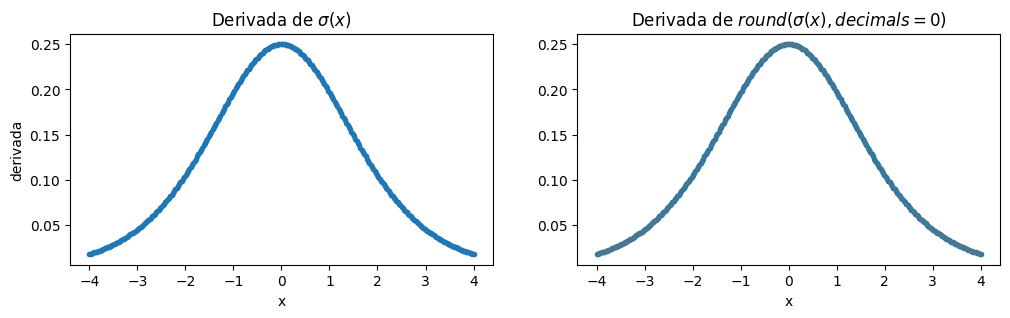

In [ ]:
x = np.linspace(-4, 4, 300).astype(np.float32)
y = tf.nn.sigmoid(x)
ry = round_sigmoid(decimals=0)(x)

pintar_figura(x, tf.nn.sigmoid, round_sigmoid(decimals=0), "\sigma(x)", [0.0], decimals=0)
pintar_derivada(x, tf.nn.sigmoid, round_sigmoid(decimals=0), "\sigma(x)", decimals=0)

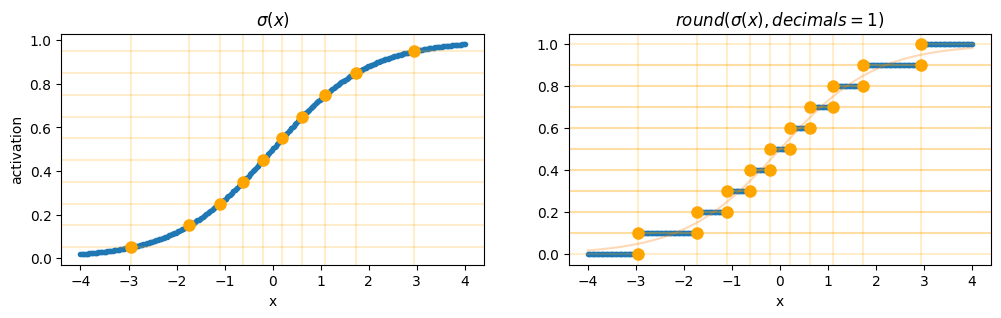

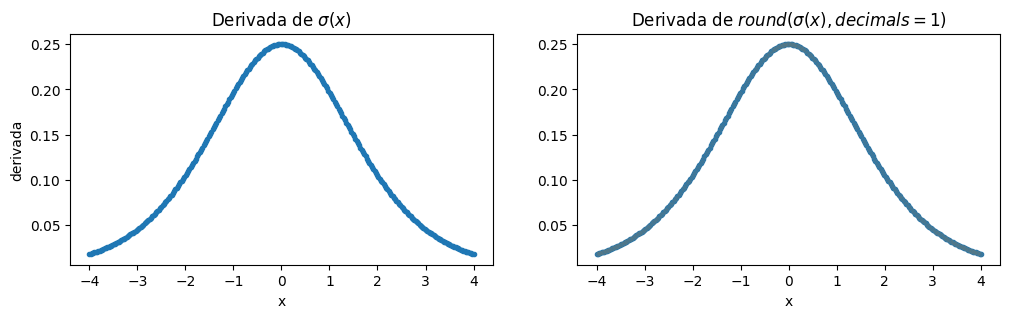

In [ ]:
x = np.linspace(-4, 4, 300).astype(np.float32)
y = tf.nn.sigmoid(x)
ry = round_sigmoid(decimals=1)(x)

pintar_figura(x, tf.nn.sigmoid, round_sigmoid(decimals=1), "\sigma(x)",
              [inv_sigmoid(i) for i in np.arange(0.05, 1.01, 0.1)],
              decimals=1)
pintar_derivada(x, tf.nn.sigmoid, round_sigmoid(decimals=1), "\sigma(x)", decimals=1)

## Tanh redondeada

In [ ]:
def round_tanh(decimals=0):
    @tf.custom_gradient
    def my_rounded_tanh(x):
        z = tf.tanh(x)
        scale = 10**decimals
        output = tf.math.round(z * scale) / scale

        def backward(dy):
            custom_grad = 1 - tf.square(z)
            return dy * custom_grad

        return output, backward
    return my_rounded_tanh

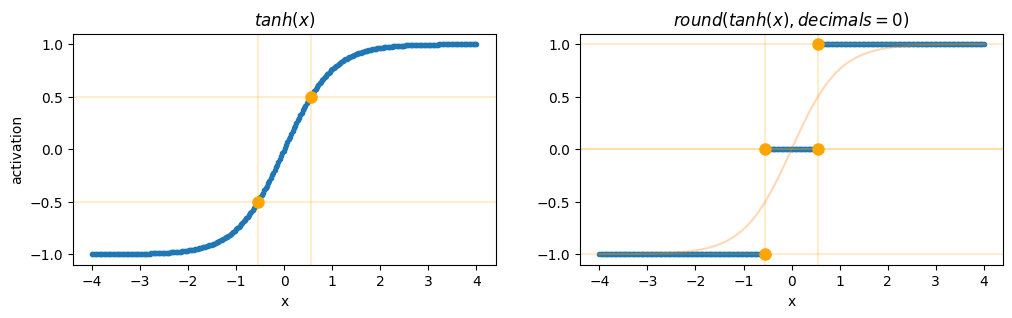

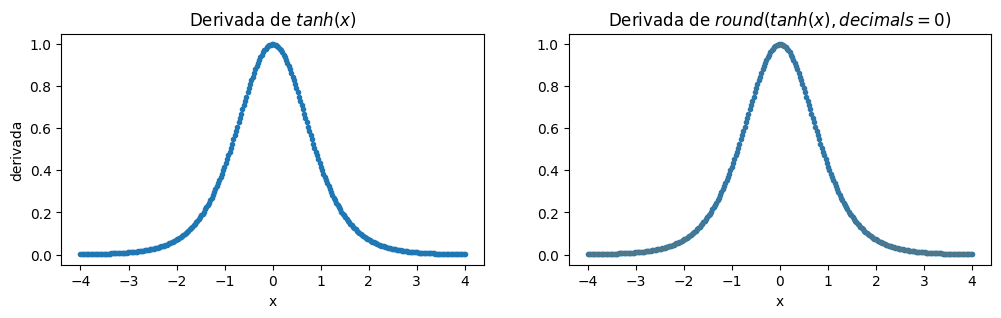

In [ ]:
x = np.linspace(-4, 4, 300).astype(np.float32)
y = tf.tanh(x)
ry = round_tanh(decimals=0)(x)

pintar_figura(x, tf.nn.tanh, round_tanh(decimals=0), "tanh(x)", [np.arctanh(-0.5), np.arctanh(0.5)], decimals=0)
pintar_derivada(x, tf.nn.tanh, round_tanh(decimals=0), "tanh(x)", decimals=0)

## ReLU redondeada

In [ ]:
def round_relu(decimals=0):
    @tf.custom_gradient
    def my_rounded_relu(x):
        z = tf.nn.relu(x)
        scale = 100**decimals
        output = tf.math.round(z*scale) / scale

        def backward(dy):
            custom_grad = tf.cast(z > 0, dtype=tf.float32)
            return dy * custom_grad

        return output, backward
    return my_rounded_relu

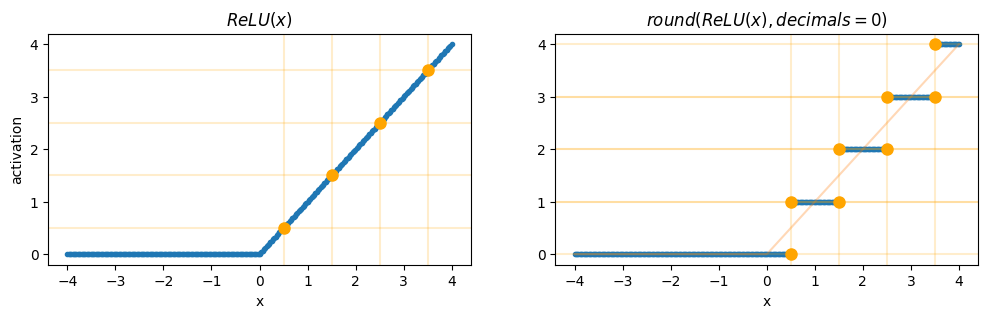

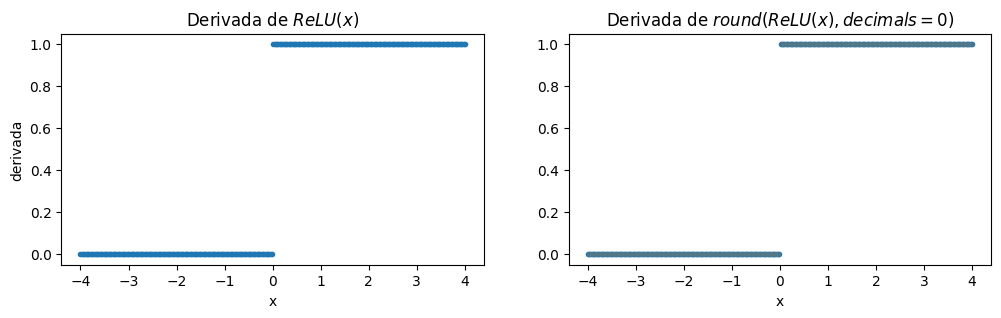

In [ ]:
x = np.linspace(-4, 4, 300).astype(np.float32)
y = tf.nn.relu(x)
ry = round_relu(decimals=0)(x)

pintar_figura(x, tf.nn.relu, round_relu(decimals=0), "ReLU(x)", [0.5, 1.5, 2.5, 3.5], decimals=0)
pintar_derivada(x, tf.nn.relu, round_relu(decimals=0), "ReLU(x)", decimals=0)

# ReLU redondeada con diferente anchura y altura del escalón

In [ ]:
def relu_ap(a=1.0, p=1.0):
    @tf.function
    def my_relu_ap(x):
        z = x / p * a
        return tf.maximum(0.0, z)
    return my_relu_ap

def round_relu_ap(a=1.0, p=1.0):
    @tf.custom_gradient
    def my_rounded_relu(x):
        z = tf.math.round(x/p) * a
        output = tf.maximum(0.0, z)

        def backward(dy):
            custom_grad = tf.cast(x > 0, dtype=tf.float32) * (a/p)
            return dy * custom_grad

        return output, backward
    return my_rounded_relu

### a=1, p=1 hace que ReLUap = ReLU

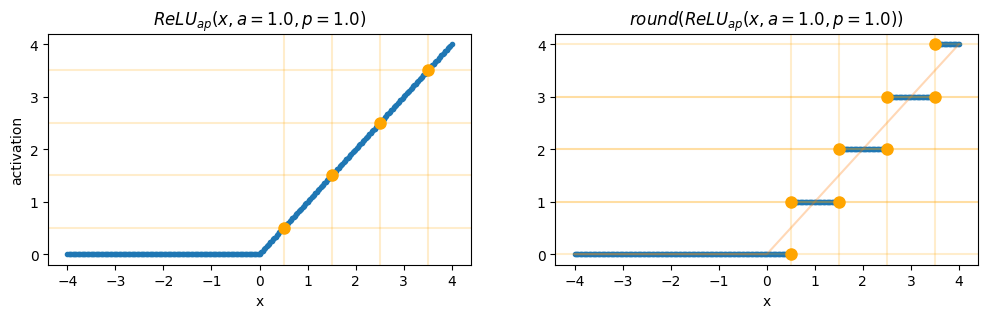

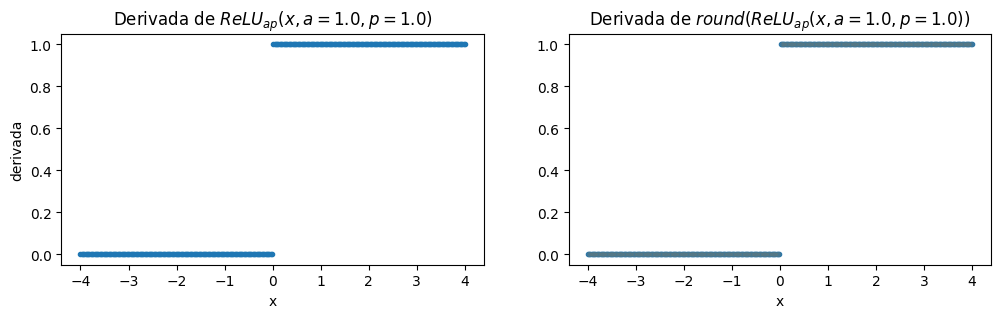

In [ ]:
a = 1.0 # altura
p = 1.0 # tamaño

x = np.linspace(-4, 4, 300).astype(np.float32)
y = relu_ap(a, p)(x)
ry = round_relu_ap(a, p)(x)

pintar_figura(x, relu_ap(a, p), round_relu_ap(a, p), "ReLU_{ap}(x, a="+str(a)+", p="+str(p)+")",
              [0.5, 1.5, 2.5, 3.5])
pintar_derivada(x, relu_ap(a, p), round_relu_ap(a, p), "ReLU_{ap}(x, a="+str(a)+", p="+str(p)+")")

### Si queremos una altura más grande, cambiamos $a$

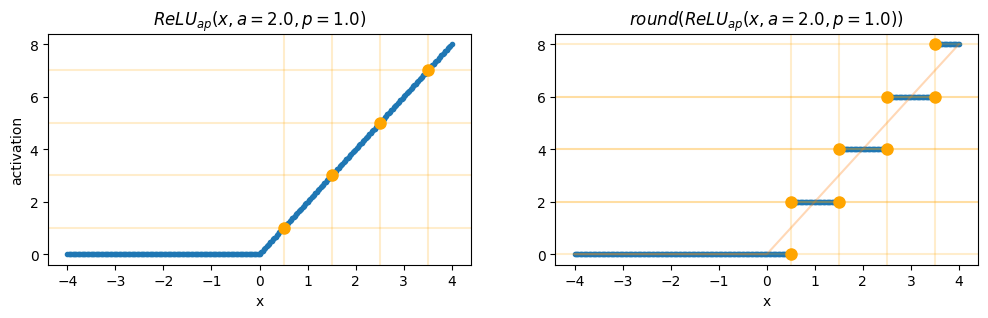

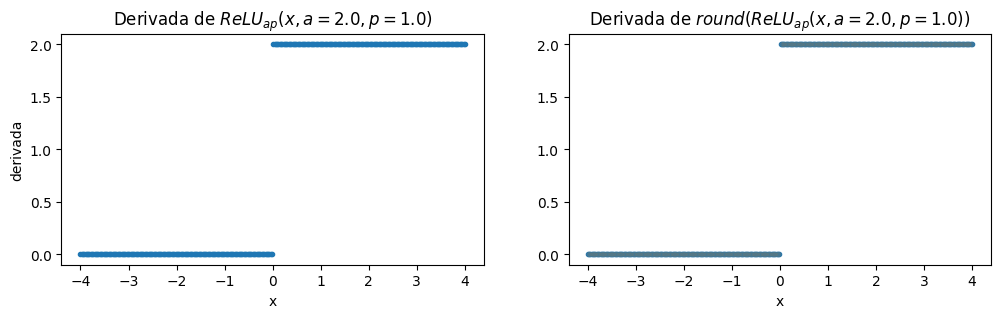

In [ ]:
a = 2.0 # altura
p = 1.0 # tamaño

x = np.linspace(-4, 4, 300).astype(np.float32)
y = relu_ap(a, p)(x)
ry = round_relu_ap(a, p)(x)

pintar_figura(x, relu_ap(a, p), round_relu_ap(a, p), "ReLU_{ap}(x, a="+str(a)+", p="+str(p)+")",
              [0.5, 1.5, 2.5, 3.5])
pintar_derivada(x, relu_ap(a, p), round_relu_ap(a, p), "ReLU_{ap}(x, a="+str(a)+", p="+str(p)+")")

### Si queremos anchura del escalón más grande, cambiamos $p$

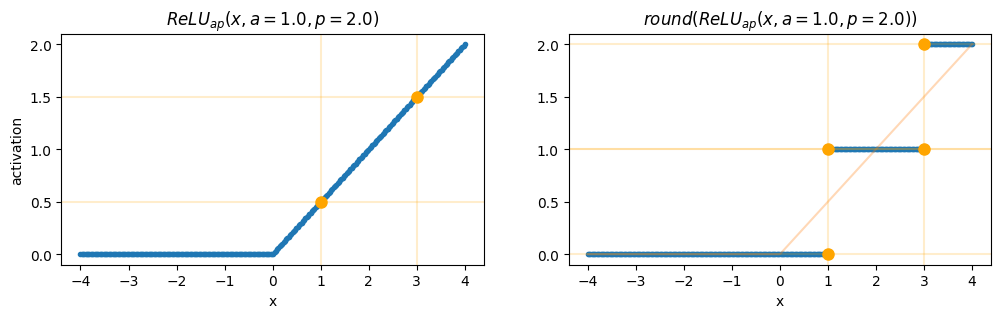

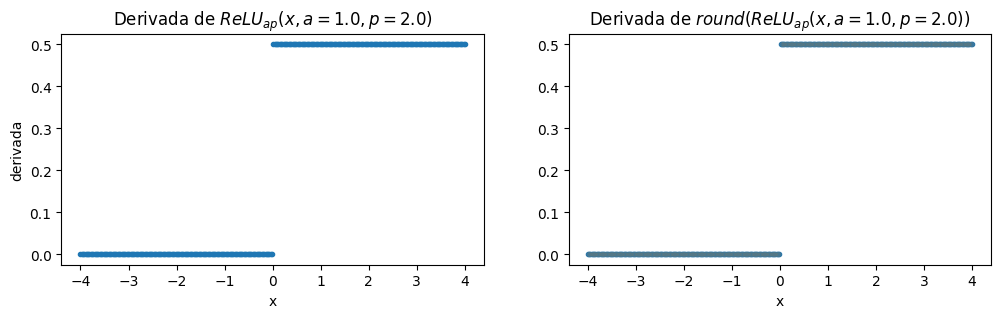

In [ ]:
a = 1.0 # altura
p = 2.0 # tamaño

x = np.linspace(-4, 4, 300).astype(np.float32)
y = relu_ap(a, p)(x)
ry = round_relu_ap(a, p)(x)

pintar_figura(x, relu_ap(a, p), round_relu_ap(a, p), "ReLU_{ap}(x, a="+str(a)+", p="+str(p)+")",
              [1.0, 3.0])
pintar_derivada(x, relu_ap(a, p), round_relu_ap(a, p), "ReLU_{ap}(x, a="+str(a)+", p="+str(p)+")")

### Por supuesto, podemos cambiar $a$ y $p$ a la vez

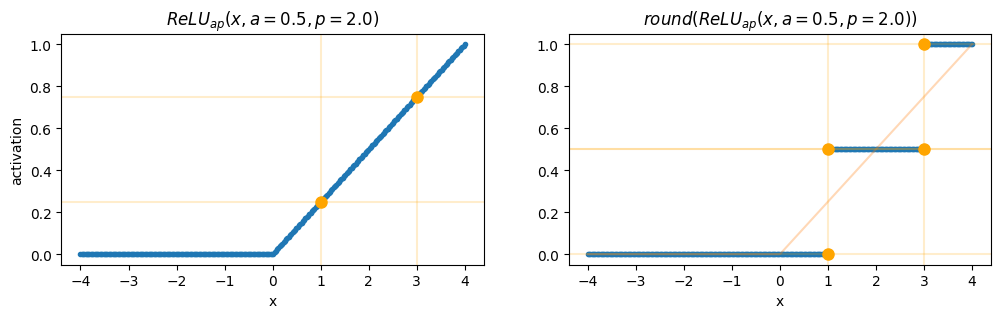

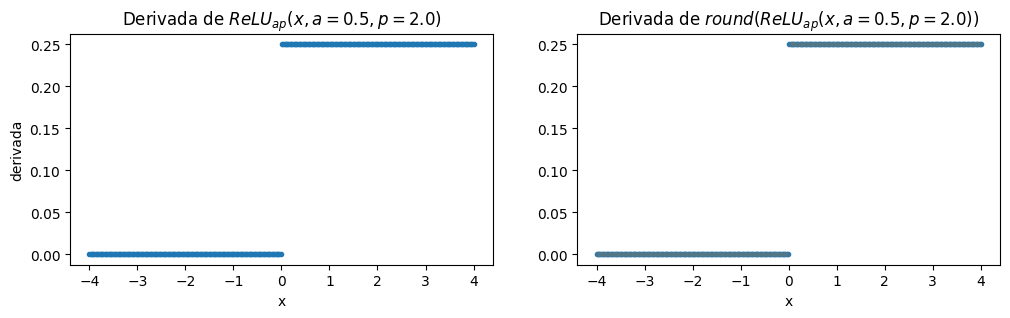

In [ ]:
a = 0.5 # altura
p = 2.0 # tamaño

x = np.linspace(-4, 4, 300).astype(np.float32)
y = relu_ap(a, p)(x)
ry = round_relu_ap(a, p)(x)

pintar_figura(x, relu_ap(a, p), round_relu_ap(a, p), "ReLU_{ap}(x, a="+str(a)+", p="+str(p)+")",
              [1.0, 3.0])
pintar_derivada(x, relu_ap(a, p), round_relu_ap(a, p), "ReLU_{ap}(x, a="+str(a)+", p="+str(p)+")")

### ¿Qué pasaría si buscamos una función escalón continua?

# Función escalón

In [ ]:
def escalon_ap(a=1.0, p=1.0):
    pi = np.pi
    w = 2 * pi / p
    @tf.function
    def my_escalon_ap(x):
        z = a/(2*pi) * (w*x - tf.sin(w*x))
        return tf.maximum(0.0, z)
    return my_escalon_ap

def round_escalon_ap(a=1.0, p=1.0):
    pi = np.pi
    w = 2 * pi / p
    @tf.custom_gradient
    def my_round_escalon(x):
        z = escalon_ap(a=a, p=p)(x)
        output = tf.math.round(z)

        def backward(dy):
            custom_grad = tf.cast(x > 0, dtype=tf.float32) * (a/p) * (1 - tf.cos(w*x))
            return dy * custom_grad

        return output, backward
    return my_round_escalon

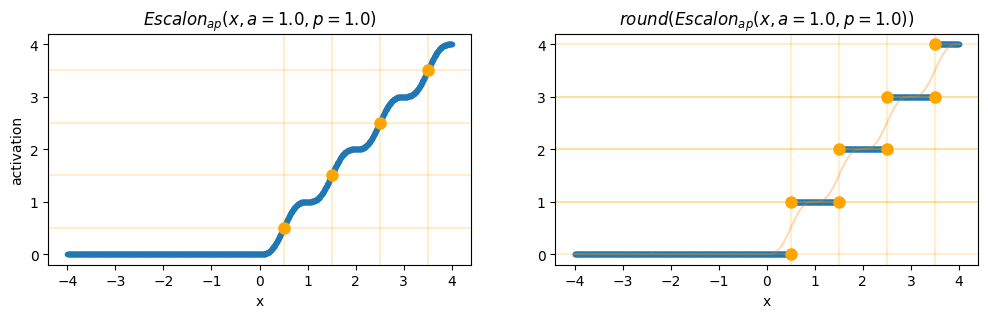

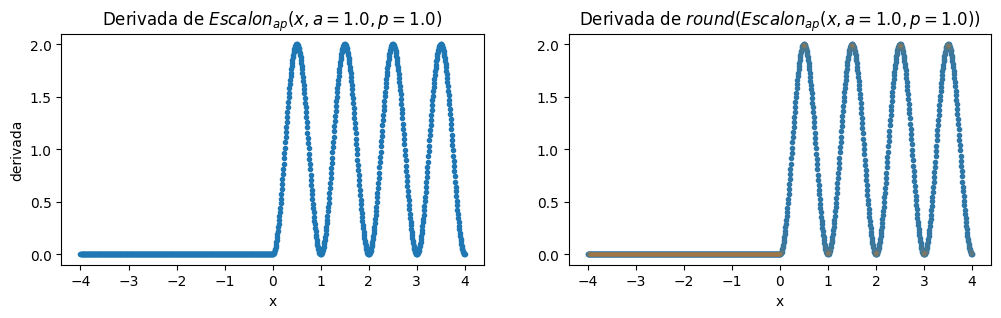

In [ ]:
a = 1.0 # altura
p = 1.0 # tamaño

x = np.linspace(-4, 4, 1000).astype(np.float32)
y = escalon_ap(a, p)(x)
ry = round_escalon_ap(a, p)(x)

pintar_figura(x, escalon_ap(a, p), round_escalon_ap(a, p), "Escalon_{ap}(x, a="+str(a)+", p="+str(p)+")",
              [0.5, 1.5, 2.5, 3.5])
pintar_derivada(x, escalon_ap(a, p), round_escalon_ap(a, p), "Escalon_{ap}(x, a="+str(a)+", p="+str(p)+")")

### El redondeo de la función escalón es igual que el redondeo de la ReLU!!

### ¿Y si usamos la derivada de esta función con la ReLU redondeada?

## ReLU redondeada con derivada escalón

In [ ]:
def relu_ap(a=1.0, p=1.0):
    @tf.function
    def my_relu_ap(x):
        z = x / p * a
        return tf.maximum(0.0, z)
    return my_relu_ap

def round_relu_ap_custom_deriv(a=1.0, p=1.0):
    pi = np.pi
    w = 2 * pi / p
    @tf.custom_gradient
    def my_rounded_relu(x):
        z = tf.math.round(x/p) * a
        output = tf.maximum(0.0, z)

        def backward(dy):
            custom_grad = tf.cast(x > 0, dtype=tf.float32) * (a/p) * (1 - tf.cos(w*x))
            return dy * custom_grad

        return output, backward
    return my_rounded_relu

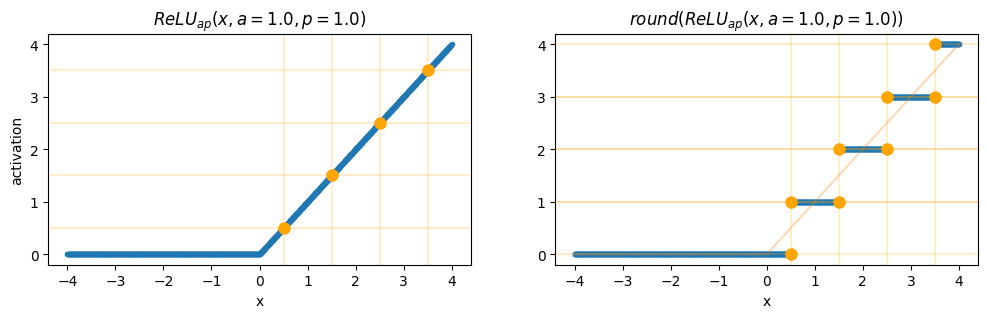

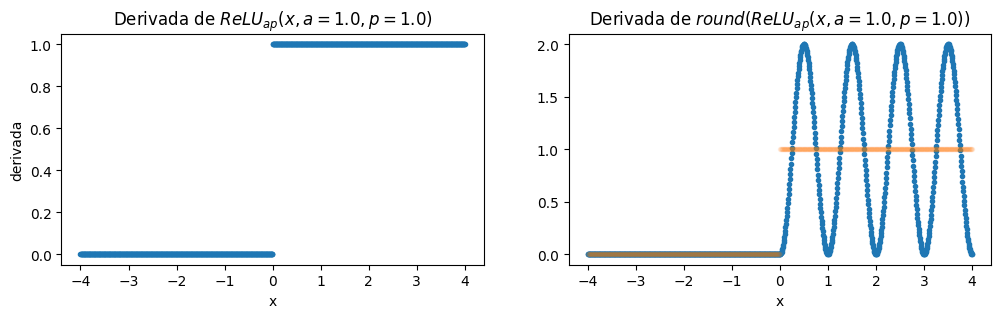

In [ ]:
a = 1.0 # altura
p = 1.0 # tamaño

x = np.linspace(-4, 4, 1000).astype(np.float32)
y = relu_ap(a, p)(x)
ry = round_relu_ap_custom_deriv(a, p)(x)

pintar_figura(x, relu_ap(a, p), round_relu_ap_custom_deriv(a, p), "ReLU_{ap}(x, a="+str(a)+", p="+str(p)+")",
              [0.5, 1.5, 2.5, 3.5])
pintar_derivada(x, relu_ap(a, p), round_relu_ap_custom_deriv(a, p), "ReLU_{ap}(x, a="+str(a)+", p="+str(p)+")")

### El valor máximo de la derivada está justo en los escalones!!

A lo mejor, nos interesa que la derivada sea alta en los bordes para movernos de ahí y estancarnos en los centros de los escalones.

### Mira como cambian las derivadas, pero siempre con los picos en los escalones!!!

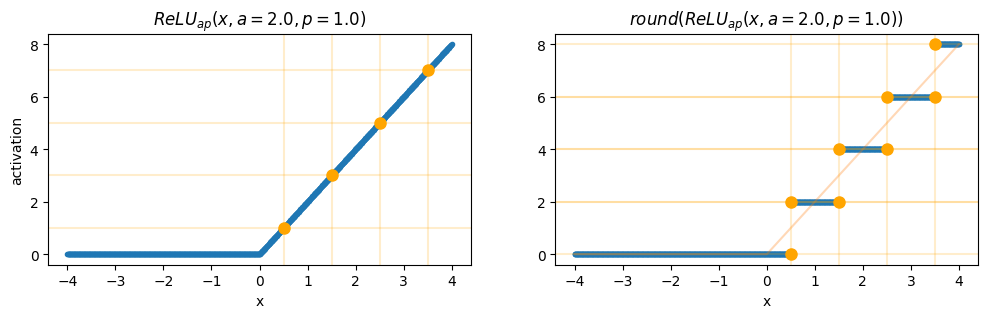

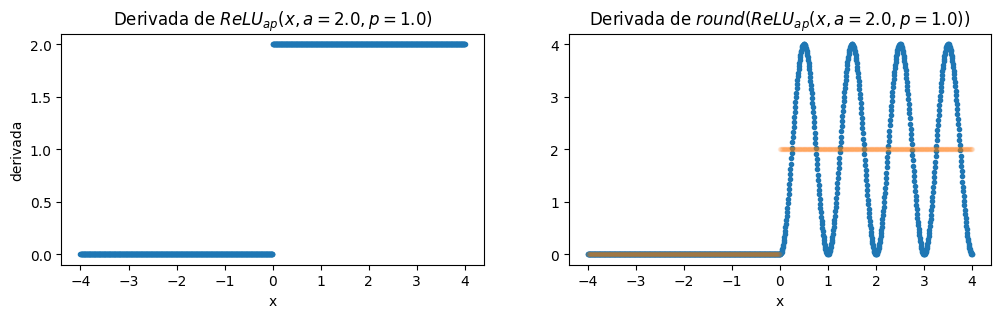

In [ ]:
a = 2.0 # altura
p = 1.0 # tamaño

x = np.linspace(-4, 4, 1000).astype(np.float32)
y = relu_ap(a, p)(x)
ry = round_relu_ap_custom_deriv(a, p)(x)

pintar_figura(x, relu_ap(a, p), round_relu_ap_custom_deriv(a, p), "ReLU_{ap}(x, a="+str(a)+", p="+str(p)+")",
              [0.5, 1.5, 2.5, 3.5])
pintar_derivada(x, relu_ap(a, p), round_relu_ap_custom_deriv(a, p), "ReLU_{ap}(x, a="+str(a)+", p="+str(p)+")")

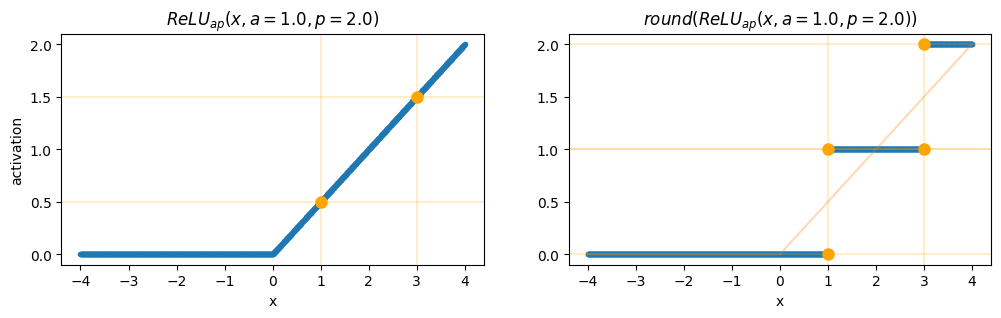

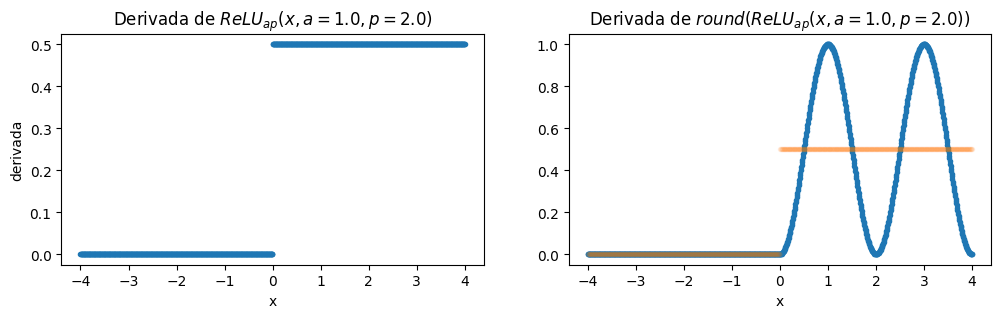

In [ ]:
a = 1.0 # altura
p = 2.0 # tamaño

x = np.linspace(-4, 4, 1000).astype(np.float32)
y = relu_ap(a, p)(x)
ry = round_relu_ap_custom_deriv(a, p)(x)

pintar_figura(x, relu_ap(a, p), round_relu_ap_custom_deriv(a, p), "ReLU_{ap}(x, a="+str(a)+", p="+str(p)+")",
              [1.0, 3.0])
pintar_derivada(x, relu_ap(a, p), round_relu_ap_custom_deriv(a, p), "ReLU_{ap}(x, a="+str(a)+", p="+str(p)+")")